[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1W-iw0V84UOi7mnCSzD9gqEm096-wGbls)

# Notebook #5: misinformation on Twitter

## Description and requirements:

In this notebook, you will learn how to quantifize misinformation in Pakistani tweets by checking whether the urls contained in tweets match with any identified fake news sources.

A requirement for this code to work is to have the Newguard data containing a list of websites publishing misinformation about COVID-19. The data that can be requested [here](https://www.newsguardtech.com/coronavirus-misinformation-tracking-center/).

### Import modules

In [1]:
import os
import json
from glob import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

path_to_data = './data'
path_to_sentiment = os.path.join(path_to_data, 'sentiment')
path_to_fake_news_domain = os.path.join(path_to_data, 'fake news domain')

### Define preprocessing functions

#### make_dirs

This function will create directories.

This function will take as an input:
- `dirs` list of directories paths to create

In [2]:
def make_dirs(dirs):
    for d in dirs:
        os.makedirs(d, exist_ok=True)

make_dirs([path_to_fake_news_domain])

#### save

This function will save a Pandas dataframe in a pickle format.

This function will take as an input:
- `df` The DataFrame to save
- `path` The path to save the file
- `name` The name of the saved file

In [3]:
def save(df, path, name):
    df.to_pickle(os.path.join(path, f'{name}.pkl'))

#### load_from_pickle

This function loads all saved pickle files to a DataFrame from a given path.

This function will take as an input:
- `path` The path to a folder containing all pickle files

This function will return a Pandas DataFrame containing all the files loaded.

In [4]:
def load_from_pickle(path):
    files = glob(os.path.join(path, '*.pkl'))
    return pd.concat([pd.DataFrame(pd.read_pickle(file)) for file in files])


#### preprocess_domain

This function will load the `Newsguard_covid_fake.txt` from `path_to_fake_news_domain` and extract the domain name from each link.
Finally, it will save the file to `clean_domain.pkl`

In [5]:
def preprocess_domain():
    domains = pd.read_csv(os.path.join(path_to_fake_news_domain, 'Newsguard_covid_fake.txt'), sep='\n', header=None)
    domains.columns = ['domain']
    domains['name'] = domains['domain'].apply(lambda url: url.split('.')[-2])
    save(domains, path_to_fake_news_domain, 'clean_domains')

preprocess_domain()

#### get_string_from_entities

Since the URLs come in a dictionary shape, we define the following function to extract these URLs from the dictionary.

This function will receive:
- `df` a dataFrame to extract the `entities` from

It will return a Pandas series, where each value is a string representation of the urls.

In [6]:
def get_string_from_entities(df):
    return pd.Series(df['entities'].apply(lambda entity: json.dumps(entity.get('urls'))))

#### if_fake_url

After extracting the URL's from the `entities` column, we would like to check if we have a URL leading to a fake news site. To achieve this, we will define the following function.

It takes as input a pandas DataFrame, loads the preprocessed domains and will search for any of them in each url, if found will return 1.
If it can't find any, it will then check if the url is empty of does it contain `twitter.com` in that case, we would want to mark this tweet as one that doesn't contain any url, and the tweet would be marked with -1.
Otherwise, we will return 0, as to say that this tweet has an url, but it is not fake.

**[Paragraph above not clear for me. Add punctuation when missing (commas) and clarify]**

In [7]:
def if_fake_url(df):
    domains = load_from_pickle(path_to_fake_news_domain)
    return df['urls'].apply(lambda urls: 1 if any([dom in urls for dom in domains['domain']]) else -1 if urls == '{}' or 'twitter.com' in urls else 0)

Now will use the data from [Notebook #3: tweet sentiment analysis](3-sentiment-analysis.ipynb) that we already cleaned and analyze it.
**[Reminder as to what the data looks like and where it comes from (Pakistani tweets, how many tweets, etc.. Can be copied from notebook #3]**

In [ ]:
# Load the df from path_to_sentiment
df = load_from_pickle(path_to_sentiment)
# Fill all missing values with ""
df.fillna(value="''", inplace=True)
# Print the head of the df to show some content
df['clean_text'].head()

**[Description of what is done in the cell below]**

In [9]:
# Get urls from entities
df['urls'] = get_string_from_entities(df)
# Mark tweets to to see who contains any fakes
df['fake_news'] = if_fake_url(df)

### Compute share of fake news links
We first filter all tweets that don't contain any URLs.

In [10]:
print(f"Total Number of fake url found is: {len(df[df['fake_news'] == 1])} out of {len(df[df['fake_news'] != -1])} tweets containing urls")
only_url = df[df['fake_news'] != -1]

Total Number of fake url found is: 6146 out of 358365 tweets containing urls


,total_daily_urls
2020-07-08,9653
2020-07-09,14272
2020-07-10,20592
2020-07-11,12000
2020-07-12,18563


We then use `.count()` on our DataFrame to count the number of tweets containing URLs, after sampling them using the `resample()` function.

In [ ]:
only_url_total = pd.DataFrame(only_url['fake_news'].resample('D').count())
only_url_total.columns = ['total_daily_urls']
only_url_total.index = [ind[:10] for ind in only_url_total.index.map(str)]
only_url_total.head()

Now get the daily sum of the tweets.
`fake_news` column will refer to the number of shared URLs considered as fake news
Here we will use the `.sum()` function to calculate how much `fake_news` tweets we have.
Because we marked each fake url using a `1` and the rest as `0` we can use the sum function to achieve this goal. 

In [11]:
daily_fake_sum = pd.DataFrame(only_url['fake_news'].resample('D').sum())
daily_fake_sum.index = only_url_total.index
daily_fake_sum = pd.concat([daily_fake_sum, only_url_total], axis=1)
daily_fake_sum.head()

,fake_news,total_daily_urls
2020-07-08,195,9653
2020-07-09,173,14272
2020-07-10,315,20592
2020-07-11,173,12000
2020-07-12,305,18563


Get the daily mean of the tweets containing fake news
We will use the `.mean()` function to calculate the daily mean of fake news urls. since we would like to see in percentages we will multiply the value by 100.
**[Not clear what the daily mean is. I guess the daily share of tweets containing fake news URLs? Please clarify. Also add commas when missing]**

In [12]:
mean_daily_fake = pd.DataFrame(only_url['fake_news'].resample('D').mean() * 100)
mean_daily_fake.columns = ['daily_fake_news_tweets_mean']
mean_daily_fake.index = only_url_total.index
mean_daily_fake = mean_daily_fake.dropna()
mean_daily_fake.head()

,daily_fake_news_tweets_mean
2020-07-08,2.020097
2020-07-09,1.212164
2020-07-10,1.529720
2020-07-11,1.441667
2020-07-12,1.643053


### Plot results

Now to plot the data and save it, we define a final function:

This function will receive:
- `df` a dataFrame to plot the information
- `ylabel` a label for the y-axis
- `xlabel` a label for the x-axis
- `title` a title for the plot
- `rotation` a variable to determine whether to rotate the text
- `ylim` a range limit on the y-axis
- `legend` a boolean (True/False) to determine whether to display a legend or not

In [13]:
def bar_plot_and_save(df, ylabel, xlabel, title, rotation=0, ylim=None, legend=True):
    # Plot the data in a `bar` format
    axes = df.plot(kind="bar", figsize=(25, 10), subplots=False)
    # Set the labels and title
    axes.set_ylabel(ylabel, fontsize=14)
    axes.set_xlabel(xlabel)
    axes.set_title(title, fontsize=22, pad=20)
    axes.tick_params(axis='both', which='major', labelsize=14)
    axes.legend(fontsize=14)
    # Go over each bar and display a text with the value above it
    for p in axes.patches:
        axes.annotate(np.round(p.get_height(), decimals=2), (p.get_x() + p.get_width() / 2, p.get_height()),
                      ha='center', va='center', rotation=rotation, xytext=(2, 20), textcoords='offset points')
    # Set a limit on the y axis if present
    if ylim is not None:
        plt.ylim(*ylim)
    # Remove the legend if not required
    if not legend:
        axes.legend().remove()
    # Save the figure to a file and display it
    plt.savefig(f"{'_'.join(title.split(' '))}", dpi='figure', bbox_inches="tight")
    plt.show()

We now plot the results:

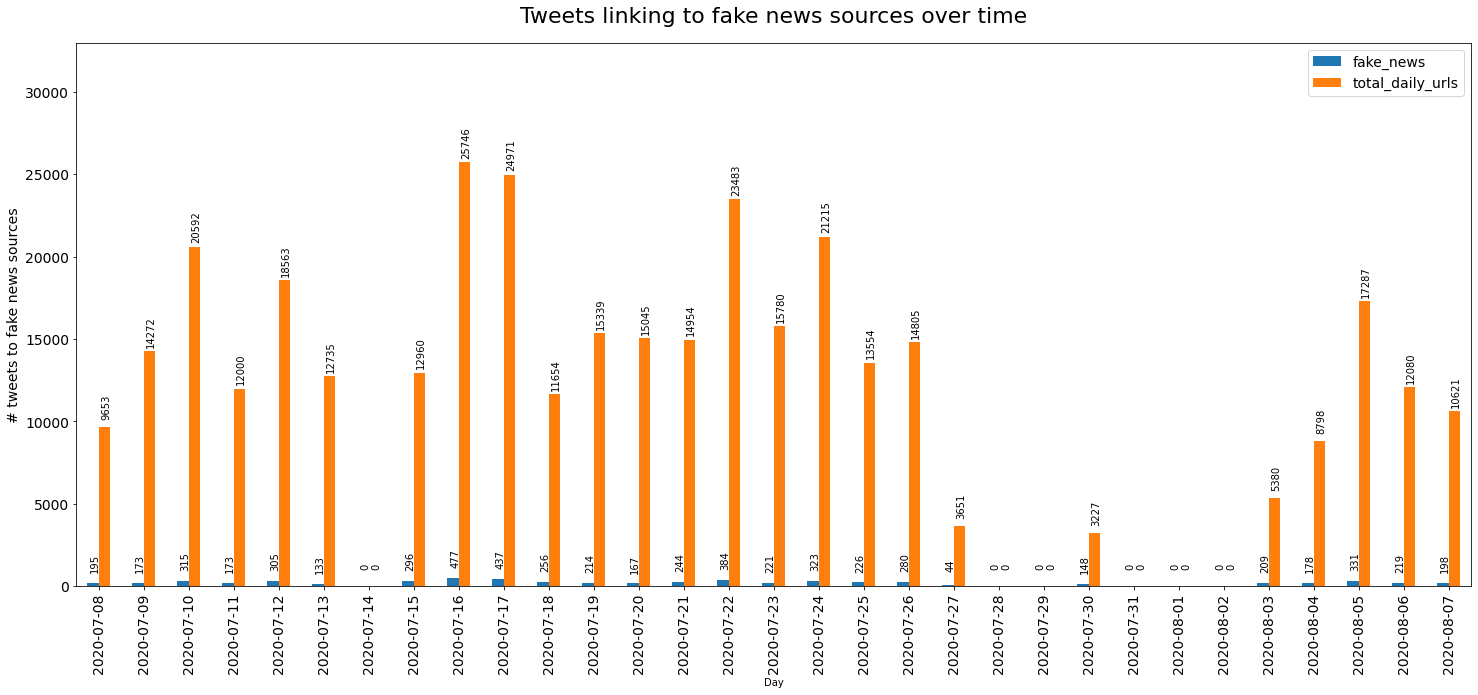

In [14]:
bar_plot_and_save(df=daily_fake_sum, ylabel='# tweets to fake news sources', xlabel='Day',
                  title='Tweets linking to fake news sources over time',
                  rotation=90, ylim=[0, 33000], legend=True)

As we can see from the plot, there are a lot of URLs being shared and only a small percentage of them are from fake news sources.
We now look at the daily share of tweets linking to fake news sources. **[Run cell below again to update title]**

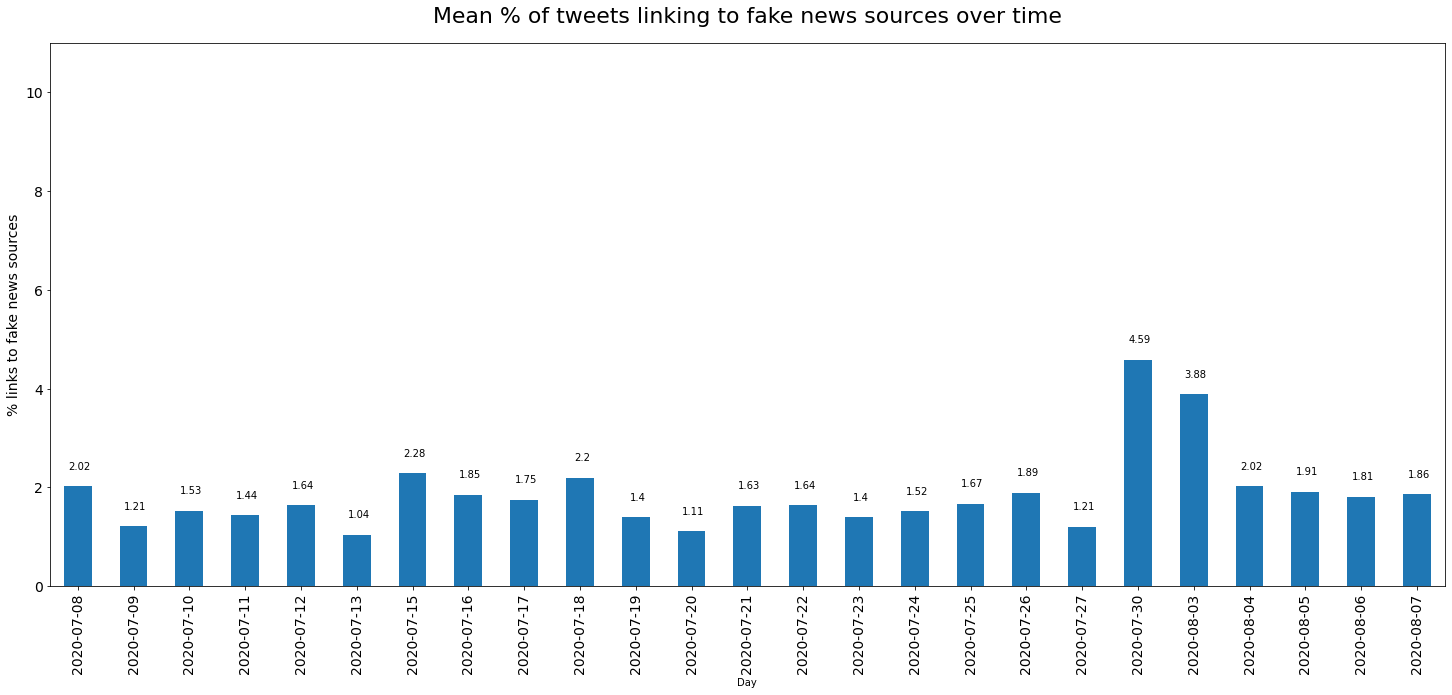

In [15]:
bar_plot_and_save(df=mean_daily_fake, ylabel='% links to fake news sources',
                  xlabel='Day',title='Daily share of tweets linking to fake news sources over time',
                  ylim=[0, 11], legend=False)

Now it is a lot clearer as to what happening.
It seems that even though on July 30th we had the least amount of data, we have the highest percentage of Fake news related links.
Even though on the 27th we have roughly the same amount of tweets collected, the percentage is not even close as it is 5 times lower.
After doing a search on the subject it seems that on the 27th of July, USA has passed the 150k death toll mark caused by COVID-19.